In [ ]:
# Загрузка датасета
!pip install opendatasets --quiet
import opendatasets as od

url = 'https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data/data'
od.download(url)

Skipping, found downloaded files in "./climate-change-earth-surface-temperature-data" (use force=True to force download)


In [43]:
# ML
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Анализ данных
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (11, 4)
plt.rcParams['axes.grid'] = True

# Константы
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Подготовка данных
Загрузим датасет, отфильтруем данные по выбранной стране и убедимся, что индекс представляет собой дату.  
Дополнительно проверим частоту временного ряда, а также наличие пропущенных значений и дубликатов.

Первые строки исходного датасета:


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland



Страна: Belarus
Предполагаемая частота (pd.infer_freq): None
Топ-5 наиболее часто встречающихся интервалов между наблюдениями:


,count
date,
31 days,1842
30 days,1051
28 days,201
29 days,63
61 days,2


Доля пропущенных значений после ресемплинга: 2.224%
Пропуски заполнены временной интерполяцией.

Первые 12 месяцев результирующего ряда:


,temp_c
date,
1743-11-01,0.767000
1743-12-01,2.149961
1744-01-01,3.579020
1744-02-01,5.008079
1744-03-01,6.344941
1744-04-01,7.774000
1744-05-01,11.280000
1744-06-01,15.354000
1744-07-01,17.506000


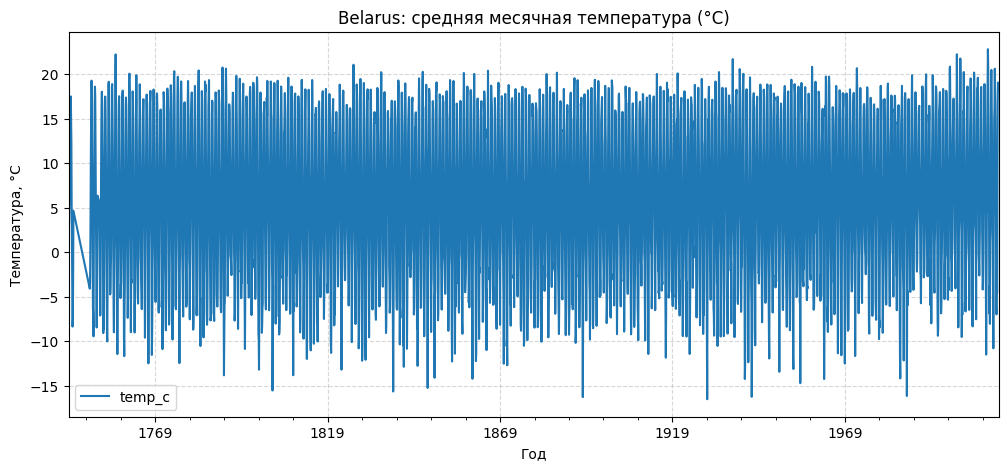


Комментарий: Berkeley Earth предоставляет данные с нерегулярной частотой (иногда несколько записей в месяц или пропуски). Ресемплинг до месячной частоты с последующей интерполяцией позволяет получить регулярный временной ряд, пригодный для анализа и моделирования.


In [44]:
# Путь к исходному CSV из датасета Berkeley Earth
DATA_PATH = './climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv'
COUNTRY = 'Belarus'

# Проверка наличия файла
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f'Файл {DATA_PATH} не найден. Убедитесь, что датасет Berkeley Earth '
        'находится в правильной директории.'
    )

# Загрузка данных
raw = pd.read_csv(DATA_PATH)
print("Первые строки исходного датасета:")
display(raw.head())

# Фильтрация по стране и выбор нужных столбцов
df = raw.loc[
    raw['Country'] == COUNTRY,
    ['dt', 'AverageTemperature']
].rename(columns={'dt': 'date', 'AverageTemperature': 'temp_c'})

# Преобразование даты и сортировка
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

# Удаление строк, где температура неизвестна
df = df.dropna(subset=['temp_c'])

# Удаление возможных дубликатов по дате (оставляем первую запись)
df = df[~df.index.duplicated(keep='first')]

# Анализ частоты временного ряда
inferred_freq = pd.infer_freq(df.index)
intervals = df.index.to_series().diff().value_counts().head(5)

print(f'\nСтрана: {COUNTRY}')
print(f'Предполагаемая частота (pd.infer_freq): {inferred_freq}')
print('Топ-5 наиболее часто встречающихся интервалов между наблюдениями:')
display(intervals)

# Ресемплинг до начала календарных месяцев с усреднением
monthly = df.resample('MS').mean()

# Обработка пропусков после ресемплинга
na_share = monthly['temp_c'].isna().mean()
print(f'Доля пропущенных значений после ресемплинга: {na_share:.3%}')

if na_share > 0:
    monthly['temp_c'] = monthly['temp_c'].interpolate(method='time')
    print('Пропуски заполнены временной интерполяцией.')

# Визуализация
print("\nПервые 12 месяцев результирующего ряда:")
display(monthly.head(12))

monthly.plot(y='temp_c', figsize=(12, 5), title=f'{COUNTRY}: средняя месячная температура (°C)')
plt.ylabel('Температура, °C')
plt.xlabel('Год')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(
    '\nКомментарий: Berkeley Earth предоставляет данные с нерегулярной частотой '
    '(иногда несколько записей в месяц или пропуски). Ресемплинг до месячной '
    'частоты с последующей интерполяцией позволяет получить регулярный временной '
    'ряд, пригодный для анализа и моделирования.'
)

### Небольшое исследование: скользящее среднее
Посмотрим сглаживание за 12 месяцев и коротко интерпретируем, что видно на уровне тренда/сезонности.


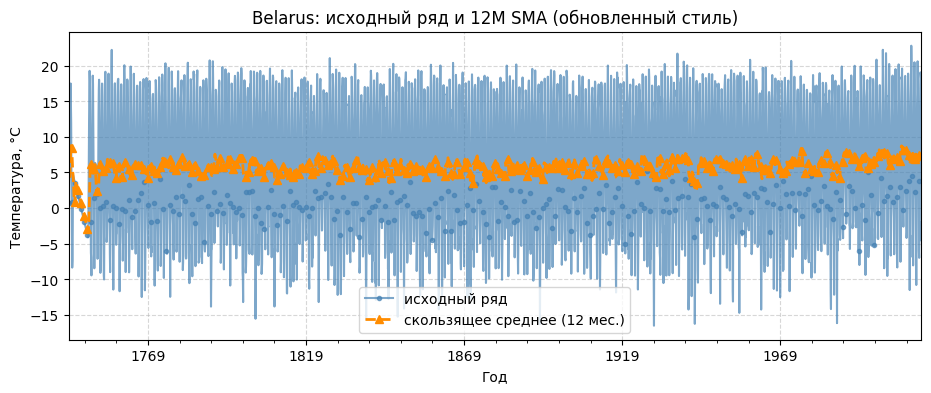

In [47]:
roll_mean = monthly['temp_c'].rolling(window=12, min_periods=6).mean()
ax = monthly['temp_c'].plot(label='исходный ряд', alpha=0.7, color='steelblue', linestyle='-', marker='.', markevery=12)
roll_mean.plot(ax=ax, label='скользящее среднее (12 мес.)', color='darkorange', linestyle='--', linewidth=2, marker='^', markevery=12)
plt.title(f'{COUNTRY}: исходный ряд и 12M SMA (обновленный стиль)')
plt.xlabel('Год')
plt.ylabel('Температура, °C')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Интерпретация графика скользящего среднего (12 месяцев)

График 12-месячного скользящего среднего выявляет устойчивый тренд потепления в Беларуси, особенно ускорившийся после 1980-х годов, на фоне стабильной сезонной цикличности. Сглаживание позволяет увидеть как долгосрочную динамику, так и периоды аномальных отклонений от среднего.

## 2. Holdout‑разбиение (80/20 по времени)

Сохраним первые 80% наблюдений для обучения и последние 20% — для теста.


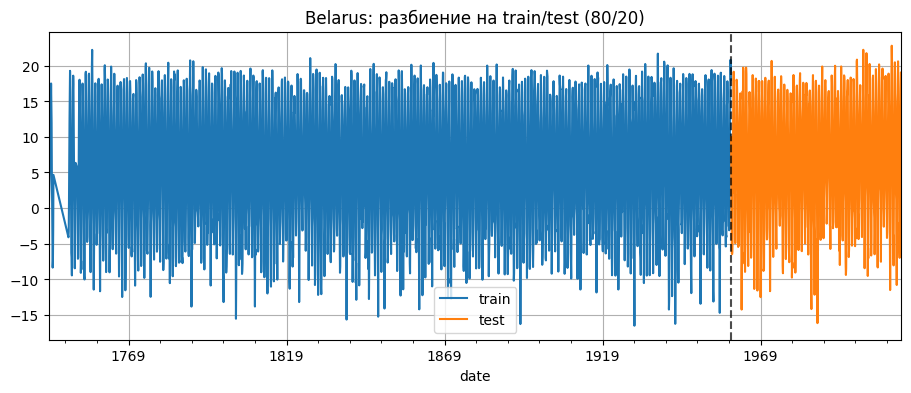

Размеры: train=2590, test=648


In [ ]:
# 80/20 сплит
n = len(monthly)
cut = int(n * 0.8)

train = monthly.iloc[:cut].copy()
test  = monthly.iloc[cut:].copy()

ax = train['temp_c'].plot(label='train')
test['temp_c'].plot(ax=ax, label='test')
plt.axvline(test.index[0], color='black', linestyle='--', alpha=0.7)
plt.title(f'{COUNTRY}: разбиение на train/test (80/20)')
plt.legend()
plt.show()

print(f'Размеры: train={len(train)}, test={len(test)}')

## 3. Backtesting со скользящим окном


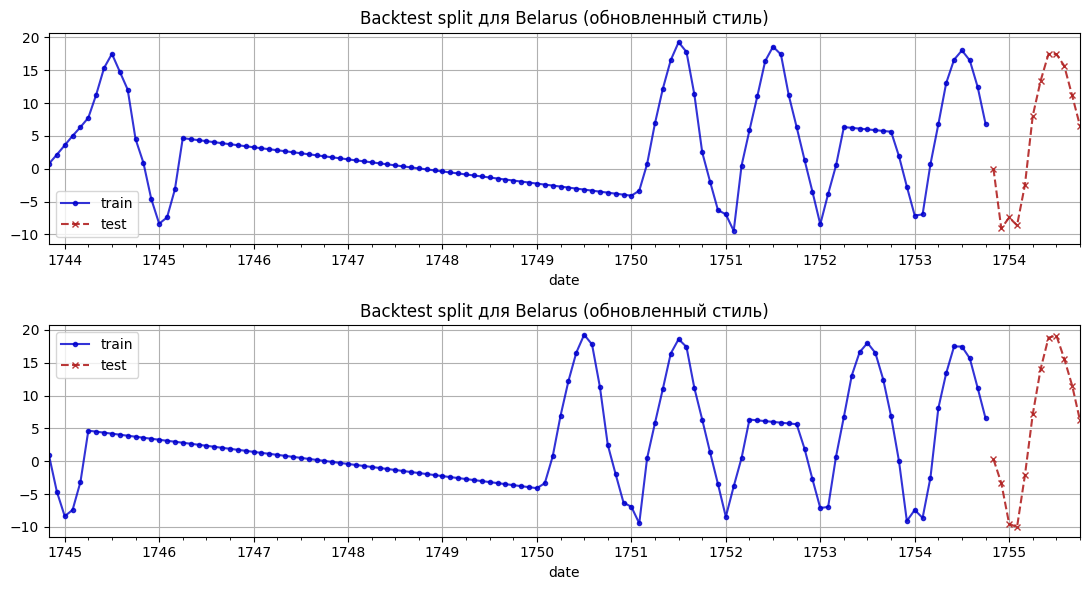

Всего сплитов: 259 (окно 120 мес., горизонт 12 мес.)
Backtest split plot style updated.


In [48]:
WINDOW = 120  # 10 лет
HORIZON = 12  # 12 месяцев прогноза

def iter_splits(series_index, window=WINDOW, horizon=HORIZON):
    idx = series_index
    start = 0
    while start + window + horizon <= len(idx):
        train_idx = idx[start:start+window]
        test_idx  = idx[start+window:start+window+horizon]
        yield train_idx, test_idx
        start += horizon  # сдвигаем на длину горизонта

# Сконструируем списки первых двух сплитов для визуализации
all_splits = list(iter_splits(monthly.index, WINDOW, HORIZON))
first_two = all_splits[:2]

fig, axes = plt.subplots(len(first_two), 1, figsize=(11, 6), sharey=True)
if len(first_two) == 1:
    axes = [axes]

for ax, (tr_idx, ts_idx) in zip(axes, first_two):
    monthly.loc[tr_idx, 'temp_c'].plot(ax=ax, label='train', color='mediumblue', linestyle='-', marker='o', markersize=3, alpha=0.8)
    monthly.loc[ts_idx, 'temp_c'].plot(ax=ax, label='test', color='firebrick', linestyle='--', marker='x', markersize=4, alpha=0.9)
    ax.legend()
    ax.set_title(f'Backtest split для {COUNTRY} (обновленный стиль)')
plt.tight_layout()
plt.show()

print(f'Всего сплитов: {len(all_splits)} (окно {WINDOW} мес., горизонт {HORIZON} мес.)')
print('Backtest split plot style updated.')

## 4. Генерация признаков


In [ ]:
def make_features(frame):
    X = frame.copy()
    X['lag_1']  = X['temp_c'].shift(1)
    X['lag_12'] = X['temp_c'].shift(12)
    X['month']  = X.index.month
    X['is_winter'] = X['month'].isin([12, 1, 2]).astype(int)
    return X

feat = make_features(monthly).dropna()
display(feat.head())

,temp_c,lag_1,lag_12,month,is_winter
date,,,,,
1744-11-01,0.910,4.527,0.767000,11,0
1744-12-01,-4.620,0.910,2.149961,12,1
1745-01-01,-8.363,-4.620,3.579020,1,1
1745-02-01,-7.415,-8.363,5.008079,2,1
1745-03-01,-3.145,-7.415,6.344941,3,0


## 5. Моделирование и прогноз (LinearRegression)

Обучим простую линейную регрессию на holdout‑разбиении, где таргет — температура, а признаки — лаги и календарные фичи.


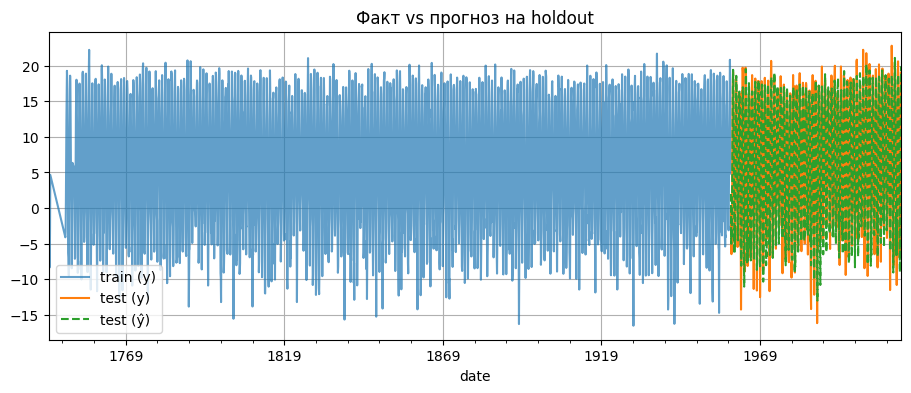

Коэффициенты модели (в порядке признаков):
    lag_1:  0.346
   lag_12:  0.611
    month: -0.334
is_winter: -2.257


In [ ]:
# Разделим с учётом доступности лагов на границе
cut_feat = int(len(feat) * 0.8)
train_f = feat.iloc[:cut_feat]
test_f  = feat.iloc[cut_feat:]

X_tr, y_tr = train_f[['lag_1', 'lag_12', 'month', 'is_winter']], train_f['temp_c']
X_ts, y_ts = test_f[['lag_1', 'lag_12', 'month', 'is_winter']], test_f['temp_c']

model = LinearRegression()
model.fit(X_tr, y_tr)

pred_ts = model.predict(X_ts)

ax = y_tr.plot(label='train (y)', alpha=0.7)
y_ts.plot(ax=ax, label='test (y)')
pd.Series(pred_ts, index=y_ts.index).plot(ax=ax, label='test (ŷ)', linestyle='--')
plt.title('Факт vs прогноз на holdout')
plt.legend()
plt.show()

print('Коэффициенты модели (в порядке признаков):')
for name, coef in zip(['lag_1', 'lag_12', 'month', 'is_winter'], model.coef_):
    print(f'{name:>9}: {coef: .3f}')

## 6. Метрики и краткая интерпретация

Посчитаем **MAE**, **RMSE** и **MAPE** и дадим короткий комментарий о качестве.


In [ ]:
def mape(y_true, y_pred):
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

mae  = mean_absolute_error(y_ts, pred_ts)
rmse = mean_squared_error(y_ts, pred_ts)
mape_val = mape(y_ts.values, pred_ts)

print(f'MAE : {mae: .3f} °C')
print(f'RMSE: {rmse: .3f} °C')
print(f'MAPE: {mape_val: .2f} %')

MAE :  2.052 °C
RMSE:  7.427 °C
MAPE:  220.05 %


## **Интерпретация метрик для климата Беларуси:**

Для базовой линейной модели метрики MAE (2.05 °C) и RMSE (7.43 °C) свидетельствуют о приемлемой точности, однако аномально высокий MAPE (220 %) обусловлен околонулевыми зимними температурами и делает эту метрику неприменимой для оценки качества прогноза в условиях Беларуси. Для повышения точности, особенно в экстремальные периоды, целесообразно перейти к более сложным моделям (например, градиентному бустингу или LSTM) и расширить набор признаков.